<a href="https://www.kaggle.com/code/kristoffhernan/autism-prediction-in-adults?scriptVersionId=98477573" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autismdiagnosis/Autism_Prediction/sample_submission.csv
/kaggle/input/autismdiagnosis/Autism_Prediction/train.csv
/kaggle/input/autismdiagnosis/Autism_Prediction/test.csv


# Predicting Autism Using Machine Learning

### Problem definition
> Given parameters about a patient, can we predict whether or not they have autism. 

### Data
The [dataset](https://www.kaggle.com/competitions/autismdiagnosis/data) is composed of survey results for more than 700 people who filed an application form. The dataset was provided by Kaggle and hosted by REVA Academy for Corporate Excellence, REVA University. 

### Evaluation
The evaluation metric for the competition is AUC-ROC score. 

### Features
**Data dictionary**

* ID - ID of the patient
* A1_Score to A10_Score - Score based on Autism Spectrum Quotient (AQ) 10 item screening tool
* age - Age of the patient in years
* gender - Gender of the patient
* ethnicity - Ethnicity of the patient
* jaundice - Whether the patient had jaundice at the time of birth
* autism - Whether an immediate family member has been diagnosed with autism
* contry_of_res - Country of residence of the patient
* used_app_before - Whether the patient has undergone a screening test before
* result - Score for AQ1-10 screening test
* age_desc - Age of the patient
* relation - Relation of patient who completed the test
* Class/ASD - Classified result as 0 or 1. Here 0 represents No and 1 represents Yes. This is the target column, and during submission submit the values as 0 or 1 only.

### Loading libraries

In [2]:
# EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Preprocessing
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Models from scikit-learn
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Model selection and scoring
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

### Loading data

In [3]:
train_df = pd.read_csv('/kaggle/input/autismdiagnosis/Autism_Prediction/train.csv')
test_df = pd.read_csv('/kaggle/input/autismdiagnosis/Autism_Prediction/test.csv')
combine = [train_df, test_df]

In [4]:
train_df.columns.values

array(['ID', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score',
       'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age',
       'gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res',
       'used_app_before', 'result', 'age_desc', 'relation', 'Class/ASD'],
      dtype=object)

**Features**

* Categorical:
    - gender (nominal: named)
    - ethnicity (nominal)
    - A1_Score to A10_Score (nominal)
    - jaundice (nominal)
    - autism (nominal)
    - country_of_res (nominal)
    - used_app_before (nominal)
    - age_desc (nominal)
    - relation (nominal)
    - Class/ASD (nominal)


* Numerical: 
    - age (continuous)
    - result (continuous)

In [5]:
# overview of first few rows
train_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


#### Fixing spelling errors

In [6]:
train_df = train_df.rename({'austim':'autism', 'contry_of_res':'country_of_res'}, axis=1)
test_df = test_df.rename({'austim':'autism', 'contry_of_res':'country_of_res'},axis=1)
combine = [train_df, test_df]

# Exploratory Data Analysis

**Missing values/percentages**

Train df (total 800 samples):
* ethnicity - 203 / 25%
* relation - 40 / 5%

Test df (total 200 samples):
* ethnicity - 54 / 27%
* relation - 6 / 3%


In [7]:
# replace '?'s with NANs
train_df = train_df.replace('[\?+]', np.nan, regex=True)
test_df = test_df.replace('[\?+]', np.nan, regex=True)

train_df.info()
print('='*45)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        597 non-null    object 
 14  jaundice         800 non-null    object 
 15  autism           800 non-null    object 
 16  country_of_res   800 non-null    object 
 17  used_app_before 

**Numerical feature distributions**

* Average age is 28.4 years old
    - The oldest patient was 89 and the youngest was 2
* Of the 800 samples, 20% of them have autism
* The average score for the AQ1-10 screening test is 8.5
* The most frequent A score was A1 with 56% choosing yes

In [8]:
train_df.describe()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result,Class/ASD
count,800.0000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,0.560000,0.530000,0.450000,0.41500,0.395000,0.303750,0.397500,0.508750,0.495000,0.617500,28.452118,8.537303,0.201250
std,231.0844,0.496697,0.499411,0.497805,0.49303,0.489157,0.460164,0.489687,0.500236,0.500288,0.486302,16.310966,4.807676,0.401185
min,1.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.718550,-6.137748,0.000000
25%,200.7500,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.198153,5.306575,0.000000
50%,400.5000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,24.848350,9.605299,0.000000
75%,600.2500,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.865429,12.514484,0.000000
max,800.0000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.461718,15.853126,1.000000


**Categorical feature distributions**

* 530/800 or 66% of the patients were men
* Out of 12 different ethnicities, White-European was the most common at 257/800 or 32%
* 615/800 patients did NOT have jaundice
* United states was the most common country of residence
* Most patients did not have autism, around 83% 
* 93% of patients havent had a screening before
* States that everyone is 18 years old or older, yet in the previous table we found that the youngest patient was 2 years old
    - I'm assuming that the age_desc column is wrong

In [9]:
train_df.describe(include=['O'])

,gender,ethnicity,jaundice,autism,country_of_res,used_app_before,age_desc,relation
count,800,597,800,800,800,800,800,760
unique,2,11,2,2,56,2,1,5
top,m,White-European,no,no,United States,no,18 and more,Self
freq,530,257,615,669,134,750,800,709


### Analyze by pivoting features

* **Gender** We observe that the proportion of male and female in the sample that have autism are similar (20%)
* **Jaundice** Those with jaundice at time of birth had a high rate of autism
* **Autism** Patients with an autistic immediate family member were more likeley to have autism as well (52%)  

In [10]:
pd.crosstab(train_df.gender, train_df['Class/ASD'])

Class/ASD,0,1
gender,,
f,215,55
m,424,106


In [11]:
train_df[['gender', 'Class/ASD']].groupby(['gender']).mean().sort_values(by='Class/ASD')

,Class/ASD
gender,
m,0.200000
f,0.203704


In [12]:
train_df[['Class/ASD', 'jaundice']].groupby(['jaundice']).mean().sort_values(by='Class/ASD')

,Class/ASD
jaundice,
no,0.170732
yes,0.302703


In [13]:
train_df[['Class/ASD', 'autism']].groupby(['autism']).mean()

,Class/ASD
autism,
no,0.137519
yes,0.526718


### Analyze by visualizing data

**Observations**

- The youngest patient that was classified as autistic was 5 years old and the oldest was 83
- Most patients were in the 5-35 age range
- The most common ages for Class/ASD = 1 are 28 and 32
- The most common ages for Class/ASD = 0 are 19

**Decision**
- Might try to group ages
- Need to round ages

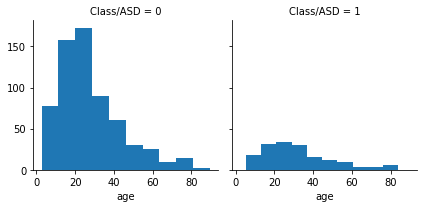

In [14]:
g = sns.FacetGrid(train_df, col='Class/ASD')
g.map(plt.hist, 'age')

In [15]:
train_df.round({'age':0}).groupby('Class/ASD')['age'].value_counts()[0]
# train_df.round({'age':0}).groupby('Class/ASD')['age'].value_counts()[1]

age
19.0    34
23.0    25
17.0    24
21.0    23
22.0    21
        ..
70.0     1
76.0     1
80.0     1
83.0     1
89.0     1
Name: age, Length: 74, dtype: int64

**Observations**
- Having autistic relatives seems to have a higher likelihood of the patient being autistic as well
    - 669 with no autistic relatives, 131 with autistic relatives


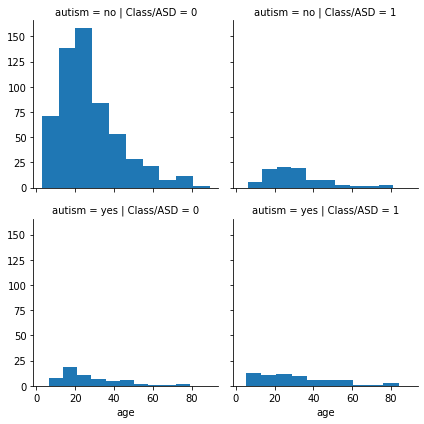

In [16]:
g = sns.FacetGrid(train_df, col='Class/ASD', row='autism')
# g = sns.FacetGrid(train_df, col='autism')
g.map(plt.hist, 'age')

In [17]:
train_df.groupby('autism')['Class/ASD'].value_counts()


autism  Class/ASD
no      0            577
        1             92
yes     1             69
        0             62
Name: Class/ASD, dtype: int64

**Observations**
- There are 49 countries of residency with less than or equal to 30 responses
    - Only 7 have have responses greater than 30 
- The patients from India have a highly disproportionate non autisti c
- Countries like Jordan, United Arab Emirates and New Zeland either have no patients with autism or only a few

**Decision**
- Create an 'other' desciption, replacing the value for countries with less than 30 responses
- I'm thinking of removing the country of response feature because the model might classify everyone who lives in New Zeland to not have autism just because the model doesnt have enough data
    - If we look at the [worldpopulationreview](https://worldpopulationreview.com/country-rankings/autism-rates-by-country) for autism, the countries do have autism
    - In fact, the United Arab Emirates is the second highest country for autism rates with 112.4 per 10k children
- Maybe instead of the country of response, I'll add a autism rate column

In [18]:
# countries where value counts are over 30
country_counts = train_df['country_of_res'].value_counts()
country_counts[country_counts <= 30].size

49

In [19]:
over30 = country_counts[country_counts > 30]
over30

United States           134
India                   108
New Zealand              78
United Kingdom           67
Jordan                   55
United Arab Emirates     40
Australia                37
Name: country_of_res, dtype: int64

In [20]:
over30_df = train_df[train_df['country_of_res'].isin(over30.keys())]

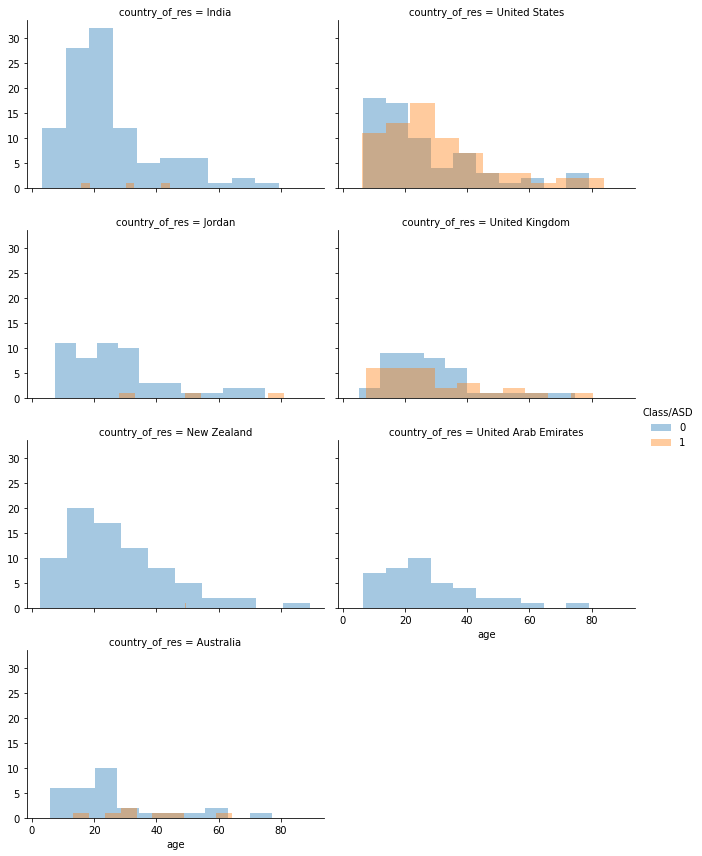

In [21]:
# india and the new zeland practically have no one with autism
g = sns.FacetGrid(over30_df, hue='Class/ASD', col='country_of_res', aspect=1.5, height=3, col_wrap=2)
g.map(plt.hist, 'age', alpha=0.4)
g.add_legend()

**Observations**
- Being male or female doesn't seem to have much effect on autism classification
    - Both males and females had similar results and age ranges for their autism classifications
    - Those with no autism had a high frequency with results in the 2.5 - 13.5 range and ages 10 - 30  range
    - Those with autism had a high frequency with results in the 10 - 15 range and ages in the 10 - 40 range 
- Males had a slightly wider age range for those with autism, but they also had more submissions
- There were more male submissions than female submissions
- Males without autism have on average slightly higher results than females without autism
- Females with autism have on average slighly higher results than males with autism
- Regardless of autism classification, females have higher standard deviations in results

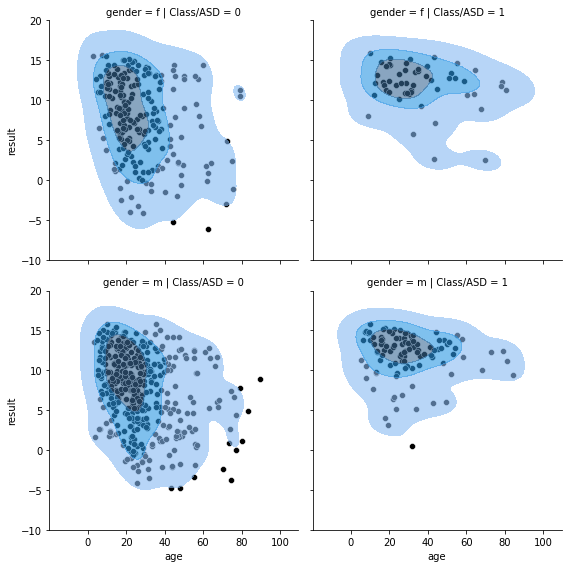

In [22]:
g = sns.FacetGrid(train_df, row='gender', col='Class/ASD', height=4, ylim=(-10,20))
# g = sns.FacetGrid(train_df, col='autism')
g.map(sns.scatterplot, 'age','result', color='k')
g.map(sns.kdeplot, 'age','result', levels=4, fill=True, alpha=0.6)


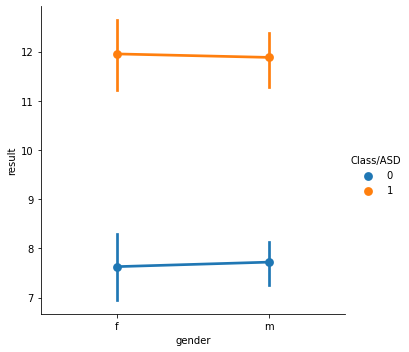

In [23]:
# females have more variability
sns.catplot(x='gender', y='result', hue='Class/ASD', kind='point', data=train_df)

**Observations**
- Generally, those that weren't autistic chose 0 for the A score and those that were chose 1
- Those who were classified as autistic rarely answered 0 on their A Score tests
- However, answering 1, doesn't mean someone is autistic
- We can see that there were a few instances like in A1, A2 and A10 score where chosing 0 or 1 was 50/50 in someone not being autistic


In [24]:
cols = list(train_df.columns)
score_df = train_df.loc[:, cols[1:11] + [cols[-1]]]

A_Scores = score_df.melt(id_vars='Class/ASD', var_name='A_Score', value_name='Scores')
A_Scores.groupby('A_Score').sum()

,Class/ASD,Scores
A_Score,,
A10_Score,161,494
A1_Score,161,448
A2_Score,161,424
A3_Score,161,360
A4_Score,161,332
A5_Score,161,316
A6_Score,161,243
A7_Score,161,318
A8_Score,161,407


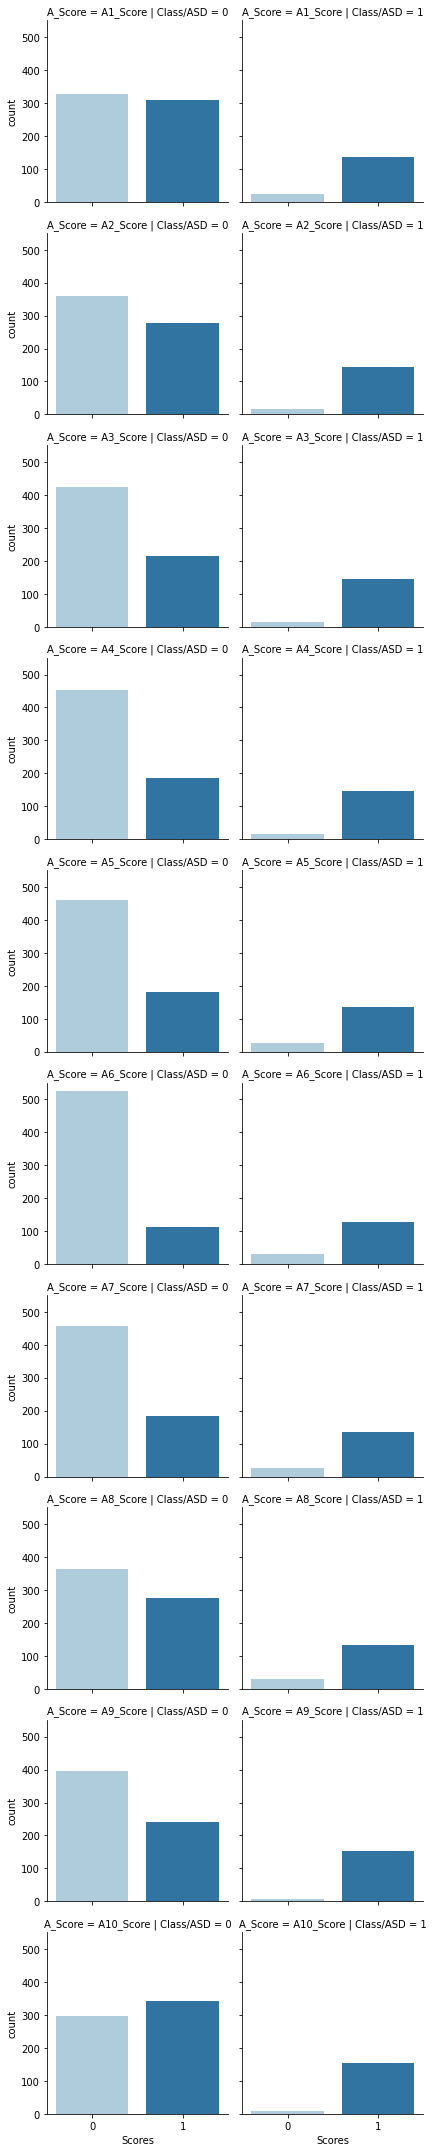

In [25]:
g = sns.FacetGrid(A_Scores, row='A_Score', col='Class/ASD')
g.map(sns.countplot,'Scores', palette='Paired', order=None)
g.add_legend()

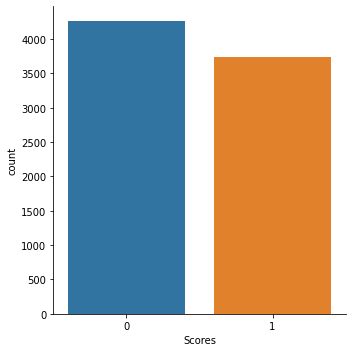

In [26]:
sns.catplot(x='Scores', kind='count', data=A_Scores)

**Observations**
- Previously using the app doesn't seem to determine someones autism classification

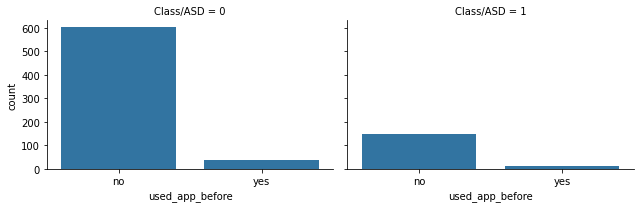

In [27]:
g = sns.FacetGrid(train_df, col='Class/ASD', aspect=1.5)
g.map(sns.countplot, 'used_app_before', order=None)

**Observations**
- There isn't much variability between the result means of those with and without jaundice for autistic patients
- There are result outliers in the autistic class while no outliers in the non autistic class
- Those with jaundice have slightly higher Q3's than those without jaundice
- Males have greater ranges in results than females regardless of autistim classification

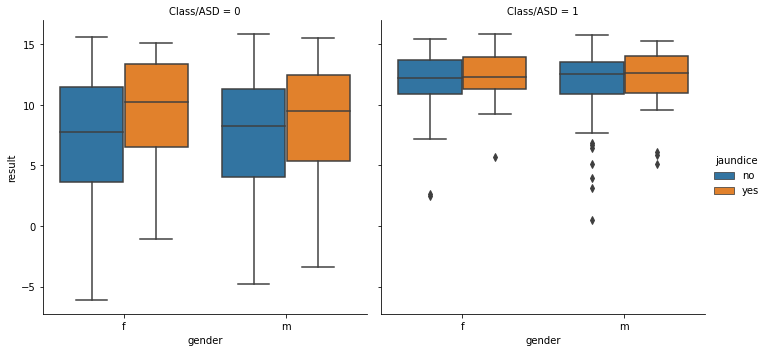

In [28]:
# those with jaundice had higher results but doesnt mean theyre more liekly to have autism
sns.catplot(x='gender', kind='box', y='result', hue='jaundice', col='Class/ASD', data=train_df)

# Data Wrangling

### Correcting by dropping features

We want to drop the ID feature because it provides no insight. We are dropping the relation feature because it was saying the very young children were doing the test by themselves. The age description feature was also droppped because it labeled children under 18 as over 18. We are also creating age bands so the age description feature would be redundant.


In [29]:
train_df_clean = train_df.drop(['ID', 'age_desc', 'relation'],axis=1)
test_df_clean = test_df.drop(['age_desc', 'relation'],axis=1)

combine = [train_df_clean, train_df_clean]

## Cleaning up dataset

**Observation**
- The ethnicity feature had two labels for others names 'others' and 'Others' 

**Decision**
- Changed 'others' to 'Others' into one group

In [30]:
train_ethnicity = train_df_clean['ethnicity'].unique()
train_ethnicity

array([nan, 'White-European', 'Middle Eastern ', 'Pasifika', 'Black',
       'Others', 'Hispanic', 'Asian', 'Turkish', 'South Asian', 'Latino',
       'others'], dtype=object)

In [31]:
for dataset in combine:
    dataset['ethnicity'] = dataset['ethnicity'].replace('others', 'Others')

combine = [train_df_clean, test_df_clean]
train_df_clean['ethnicity'].unique()

array([nan, 'White-European', 'Middle Eastern ', 'Pasifika', 'Black',
       'Others', 'Hispanic', 'Asian', 'Turkish', 'South Asian', 'Latino'],
      dtype=object)

**Observation**
- Many countries appeared less than 5 times
- Low sample sizes of countries could mess up model

**Decision**
- Kept the top 10 most frequent countries and gave the rest an 'Others' class

In [32]:
top_10_countries = train_df_clean['country_of_res'].value_counts(ascending=False)[0:10].keys()
top_10_countries

Index(['United States', 'India', 'New Zealand', 'United Kingdom', 'Jordan',
       'United Arab Emirates', 'Australia', 'Canada', 'Afghanistan',
       'Netherlands'],
      dtype='object')

In [33]:
for dataset in combine:
    dataset.loc[~dataset['country_of_res'].isin(top_10_countries), 'country_of_res'] = 'Others'

combine = [train_df_clean, test_df_clean]
train_df_clean['country_of_res'].unique()

array(['Others', 'India', 'United States', 'Jordan', 'United Kingdom',
       'New Zealand', 'Canada', 'United Arab Emirates', 'Australia',
       'Netherlands', 'Afghanistan'], dtype=object)

## Imputer

To fill in missing values

In [34]:
# imputer vs fillna
# https://www.kaggle.com/questions-and-answers/168079


# fill categorical values with 'missing'
cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing')
# fill numerical values with mean
num_imputer = SimpleImputer(strategy='mean')
# there are no values missing in autism, just an example of another imputer
aut_imputer = SimpleImputer(strategy='constant', fill_value='no')

# define columns
cat_features = ['ethnicity', 'country_of_res']
num_features = ['result', 'age']
aut_feature = ['autism']


# create an imputer (something that fills missing data)
imputer = ColumnTransformer([
    ('cat_imputer', cat_imputer, cat_features),
    ('num_imputer', num_imputer, num_features),
    ('aut_imputer', aut_imputer, aut_feature)
])

filled_train_df = imputer.fit_transform(train_df_clean)
filled_test_df = imputer.fit_transform(test_df_clean)

In [35]:
train_imputed_features = pd.DataFrame(filled_train_df, columns=['ethnicity', 'country_of_res', 'result', 'age','autism'])
test_imputed_features = pd.DataFrame(filled_test_df, columns=['ethnicity', 'country_of_res', 'result', 'age','autism'])
train_imputed_features.head()

,ethnicity,country_of_res,result,age,autism
0,Missing,Others,6.351166,38.172746,no
1,Missing,India,2.255185,47.750517,no
2,White-European,United States,14.851484,7.380373,yes
3,Missing,United States,2.276617,23.561927,no
4,Missing,Others,-4.777286,43.20579,no


In [36]:
train_df_clean[['ethnicity', 'country_of_res', 'result', 'age','autism']] = train_imputed_features
test_df_clean[['ethnicity', 'country_of_res', 'result', 'age','autism']] = test_imputed_features

combine = [train_df_clean, test_df_clean]
train_df_clean.isna().sum()

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jaundice           0
autism             0
country_of_res     0
used_app_before    0
result             0
Class/ASD          0
dtype: int64

## Numerical bands

In [37]:
def create_band(train_df, test_df, band_name, original, bin_count):
    # find the correlation betweeen band and autism 
    train_df[band_name] = pd.cut(train_df[original], bin_count)
    band_corr = train_df[[band_name, 'Class/ASD']].groupby(band_name, as_index=False).mean()
    
    # create a result band on 5 bins that can be replicated to the test df later  
    # automatically encodes the bins into 0,1,3 ...     
    est = KBinsDiscretizer(n_bins=bin_count, encode='ordinal', strategy='uniform')
    reshaped_col = train_df[original].values.reshape(-1,1)
    est.fit(reshaped_col)
    Xt = est.transform(reshaped_col)

    # overwrite original result feature with encoded result band 
    train_df[original] = pd.Series(Xt.flatten().astype(int))
    
    # perform the same thing on the test df but with the bins from the train df
    bins = est.bin_edges_[0]
    test_df[band_name] = pd.cut(test_df[original], bins=bins)

    # initialize encoder
    le = LabelEncoder()
    # fit encoder
    test_df[original] = le.fit_transform(test_df[band_name])
    
    # drop band columns 
    train_df.drop(band_name, axis=1, inplace=True)
    test_df.drop(band_name, axis=1, inplace=True)
    
    return band_corr

**Result band**

Result band and its correlation with autism classification

In [38]:
create_band(train_df_clean, test_df_clean, 'result_band', 'result', 5)

,result_band,Class/ASD
0,"(-6.16, -1.74]",0.000000
1,"(-1.74, 2.659]",0.030303
2,"(2.659, 7.057]",0.065789
3,"(7.057, 11.455]",0.165975
4,"(11.455, 15.853]",0.381625


In [39]:
train_df_clean.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,autism,country_of_res,used_app_before,result,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38.172746,f,Missing,no,no,Others,no,2,0
1,0,0,0,0,0,0,0,0,0,0,47.750517,m,Missing,no,no,India,no,1,0
2,1,1,1,1,1,1,1,1,1,1,7.380373,m,White-European,no,yes,United States,no,4,1
3,0,0,0,0,0,0,0,0,0,0,23.561927,f,Missing,no,no,United States,no,1,0
4,0,0,0,0,0,0,0,0,0,0,43.20579,m,Missing,no,no,Others,no,0,0


**Age band**

Age band and its correlation with autism classification

In [40]:
create_band(train_df_clean, test_df_clean, 'age_band', 'age', 4)

,age_band,Class/ASD
0,"(2.632, 24.404]",0.154430
1,"(24.404, 46.09]",0.234694
2,"(46.09, 67.776]",0.265060
3,"(67.776, 89.462]",0.321429


In [41]:
train_df_clean.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,autism,country_of_res,used_app_before,result,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,1,f,Missing,no,no,Others,no,2,0
1,0,0,0,0,0,0,0,0,0,0,2,m,Missing,no,no,India,no,1,0
2,1,1,1,1,1,1,1,1,1,1,0,m,White-European,no,yes,United States,no,4,1
3,0,0,0,0,0,0,0,0,0,0,0,f,Missing,no,no,United States,no,1,0
4,0,0,0,0,0,0,0,0,0,0,1,m,Missing,no,no,Others,no,0,0


## Label Encoding

In [42]:
def label_encoder(train_df, test_df, feature):
    # initialize encoder
    le = LabelEncoder()
    # fit encoder
    train_df[feature] = le.fit_transform(train_df[feature])
    test_df[feature] = le.fit_transform(test_df[feature])

In [43]:
features_to_encode = ['gender', 'jaundice', 'autism', 'used_app_before', 'ethnicity', 'country_of_res']
for feature in features_to_encode:
    label_encoder(train_df_clean, test_df_clean, feature)
    
train_df_clean.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,autism,country_of_res,used_app_before,result,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,1,0,5,0,0,7,0,2,0
1,0,0,0,0,0,0,0,0,0,0,2,1,5,0,0,3,0,1,0
2,1,1,1,1,1,1,1,1,1,1,0,1,10,0,1,10,0,4,1
3,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,10,0,1,0
4,0,0,0,0,0,0,0,0,0,0,1,1,5,0,0,7,0,0,0


## One Hot Encoder

**OPTION 2, ONE HOT ENCODING, INSTEAD OF LABEL ENCODING**

**OPTION 3, PD DUMMIES**

In [44]:
# from sklearn.preprocessing import  OneHotEncoder

# categorical_features = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
#        'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
#        'ethnicity', 'jaundice', 'autism', 'country_of_res', 'used_app_before',
#        'result']
# ohe = OneHotEncoder()

# transformer = ColumnTransformer([
#     ('one_hot',ohe, categorical_features)
# ], remainder='passthrough')

# transformed_train = transformer.fit_transform(train_df)
# transformed_test = transformer.fit_transform(test_df)

## Correlation Matrix

Now that everything is encoded, lets look at a correlation matrix

- Gender, age and using the app before are the worst correlators
- The best correlators are the A Scores

<AxesSubplot:>

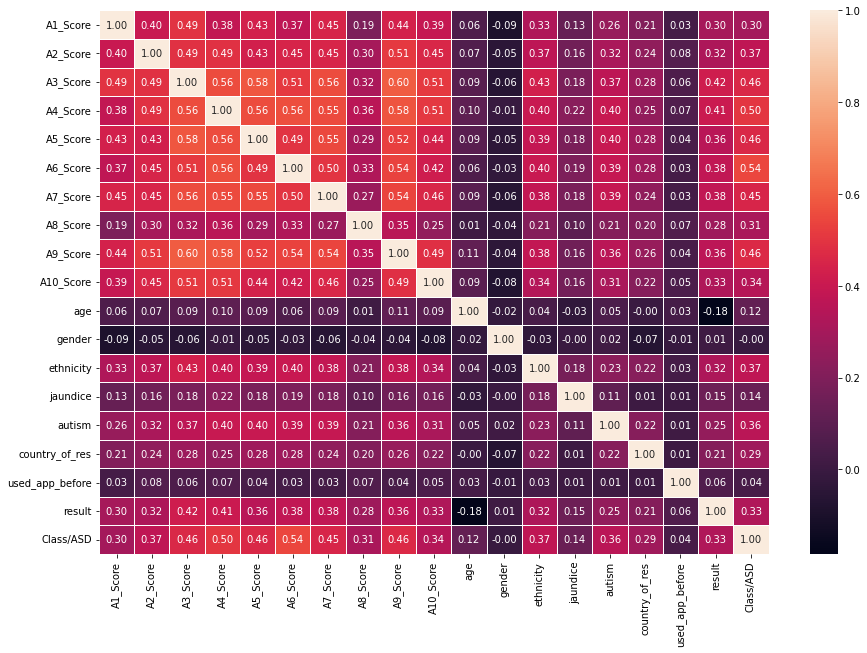

In [45]:
corr_matrix = train_df_clean.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,
           annot=True, # adding the numbers
           linewidths=0.5, # spacing betwen boxes
           fmt='0.2f')

# Modeling

Because our data didn't look that normal, we had to [normalize](https://stackoverflow.com/questions/52670012/convergencewarning-liblinear-failed-to-converge-increase-the-number-of-iterati) it. [Normalizing](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) the data by centering it around the mean. 

In [46]:
np.random.seed(10)
scaler = StandardScaler()
scaler.fit(train_df_clean.drop('Class/ASD', axis=1))

# transform both train and test df's
X_train_normalized = scaler.transform(train_df_clean.drop('Class/ASD', axis=1))
X_test_normalized = scaler.transform(test_df_clean.drop('ID', axis=1))

y_train = train_df_clean['Class/ASD']

X_train_normalized.shape, y_train.shape, X_test_normalized.shape

((800, 18), (800,), (200, 18))

## Base Model Testing

Testing models with base arguments

**Oberservations**
- Best model was Log Reg
- Followed by Linear SVC, Random Forest and SVC

| Model               | Base AUC Score |
|---------------------|-----------|
| KNC                 | 0.86353   |
| Logistic Regression | 0.90792   |
| Random Forest       | 0.894761  |
| Linear SVC          | 0.906776  |
| SVC                 | 0.88691   |
| Decision Tree       | 0.72159   |

In [47]:
def model_scoring(model, X_train, y_train):
    scores = {'AUC':None,
              'Accuracy':None,
               'F1':None,
               'Precision':None,
               'Recall':None
              }
    
    cv_auc = cross_val_score(model,
                    X_train,
                    y_train,
                    cv=5,
                    scoring='roc_auc')
    auc = np.mean(cv_auc)
    scores['AUC'] = auc
    
    cv_acc = cross_val_score(model,
                    X_train,
                    y_train,
                    cv=5,
                    scoring='accuracy')
    acc = np.mean(cv_acc)
    scores['Accuracy'] = acc
        
    cv_f1 = cross_val_score(model,
                    X_train,
                    y_train,
                    cv=5,
                    scoring='f1')
    f1 = np.mean(cv_f1)
    scores['F1'] = f1
        
    cv_precision = cross_val_score(model,
                    X_train,
                    y_train,
                    cv=5,
                    scoring='precision')
    f1 = np.mean(cv_precision)
    scores['Precision'] = f1
    
    cv_recall = cross_val_score(model,
                    X_train,
                    y_train,
                    cv=5,
                    scoring='recall')
    recall = np.mean(cv_recall)
    scores['Recall'] = recall
    
    return scores

In [48]:
# putting models into a dictionary
models = {
    'KNC': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Linear SVC': LinearSVC(dual=False), # dual=False when n samples > n features
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier()
}

base_model_auc = {}
for name, model in models.items():
    model.fit(X_train_normalized, y_train)
    cv_auc = cross_val_score(model,
                    X_train_normalized,
                    y_train,
                    cv=5,
                    scoring='roc_auc')
    auc = np.mean(cv_auc)
    base_model_auc[name] = auc

In [49]:
base_model_auc

{'KNC': 0.8635316645322566,
 'Logistic Regression': 0.9079226691123836,
 'Random Forest': 0.8982839028666338,
 'Linear SVC': 0.9067762509134157,
 'SVC': 0.8869132935531496,
 'Decision Tree': 0.7107024993568809}

## Hyper parameter tuning with RandomizedSearchCV

Creating parameter grids before fitting


| Model               | Base AUC Score | RS CV AUC Score |
|---------------------|----------------|-----------------|
| KNC                 | 0.86353        | 0.83031         |
| Logistic Regression | 0.90792        | 0.90876         |
| Random Forest       | 0.894761       | 0.90992         |
| Linear SVC          | 0.906776       | 0.90423         |
| SVC                 | 0.88691        | 0.903229        |
| SVC1                | NA             | 0.830315        |
| Decision Tree       | 0.72159        | NA              |

In [50]:
log_reg_grid = {
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear']
}

lin_svc_grid = {
    'C': np.logspace(-1, 4, 6),
    'dual': [False],
    'fit_intercept': [False],
}

# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769
svc_grid = {
    'C': np.logspace(-1, 4, 6),
    'kernel': ['poly'],
    'degree': np.arange(0,6,1).astype(int),
}

svc_grid1 = {
    'C': np.logspace(-1, 4, 6),
    'kernel': ['rbf'],
    'gamma': np.logspace(-1, 2, 4)
}

# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
rf_grid = {
    'n_estimators': np.linspace(100, 900, 9).astype(int),
    'max_features': ['auto', 'sqrt'],
    'max_depth': np.linspace(10, 100, 10).astype(int),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

knc_grid = {
    'n_neighbors': np.arange(3,10,1),
    'weights': ['uniform', 'distance'],
    'leaf_size': np.arange(20,100,5)
}

# copied models dictionary from ealier
models = {
    'KNC': [KNeighborsClassifier(), knc_grid, 20],
    'Logistic Regression': [LogisticRegression(), log_reg_grid, 20],
    'Random Forest': [RandomForestClassifier(), rf_grid, 20],
    'Linear SVC': [LinearSVC(), lin_svc_grid, 6],
    'SVC': [SVC(), svc_grid, 20],
    'SVC1': [SVC(), svc_grid1, 20],
}

In [51]:
# finding thebest parameters using RandomizedSearchCV

model_best_params = {}

for name, model_pack in models.items():
    model, grid, n_iter = model_pack
    
    np.random.seed(10)
    rs = RandomizedSearchCV(model,
                      param_distributions=grid,
                      cv=5,
                      n_iter=n_iter,
                      verbose=True)
    rs.fit(X_train_normalized, y_train)
    best_params = rs.best_params_
    
    model_best_params[name] = best_params

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [52]:
model_best_params

{'KNC': {'weights': 'uniform', 'n_neighbors': 6, 'leaf_size': 45},
 'Logistic Regression': {'solver': 'liblinear', 'C': 0.08858667904100823},
 'Random Forest': {'n_estimators': 900,
  'min_samples_split': 10,
  'max_features': 'sqrt',
  'max_depth': 90,
  'bootstrap': True},
 'Linear SVC': {'fit_intercept': False, 'dual': False, 'C': 0.1},
 'SVC': {'kernel': 'poly', 'degree': 3, 'C': 0.1},
 'SVC1': {'kernel': 'rbf', 'gamma': 0.1, 'C': 10.0}}

**KNeighborsClassifier Scoring**

In [53]:
# rs_knc_score = model_scoring(KNeighborsClassifier(**model_best_params['KNC']), X_train_normalized, y_train)
# rs_knc_score

# rs_lr_score = model_scoring(LogisticRegression(**model_best_params['Logistic Regression']), X_train_normalized, y_train)
# rs_lr_score

# rs_rfc_score = model_scoring(RandomForestClassifier(**model_best_params['Random Forest']), X_train_normalized, y_train)
# rs_rfc_score

# rs_lsvc_score = model_scoring(LinearSVC(**model_best_params['Linear SVC']), X_train_normalized, y_train)
# rs_lsvc_score

# rs_svc_score = model_scoring(SVC(**model_best_params['SVC']), X_train_normalized, y_train)
# rs_svc_score

# rs_svc1_score = model_scoring(SVC(**model_best_params['SVC1']), X_train_normalized, y_train)
# rs_svc1_score

**LogisticRegression Scoring**

**RandomForestClassifier Scoring**

**LinearSVC Scoring**

**SVC Scoring**

**SVC1 Scoring**

## Hypeparameter tuning with GridSearchCV

In [54]:
# copied models dictionary from ealier but removing SVC1, KNC and Linear SVC (maybe)
models = {
    'Logistic Regression': [LogisticRegression(), log_reg_grid, 20],
    'Random Forest': [RandomForestClassifier(), rf_grid, 20],
    'Linear SVC': [LinearSVC(), lin_svc_grid, 6],
    'SVC': [SVC(), svc_grid, 20],
}

In [55]:
# finding thebest parameters using GrisSearchCV

model_best_params = {}

for name, model_pack in models.items():
    model, grid, n_iter = model_pack
    
    np.random.seed(10)
    rs = GridSearchCV(model,
                      param_grid=grid,
                      cv=5,
                      verbose=True)
    rs.fit(X_train_normalized, y_train)
    best_params = rs.best_params_
    
    model_best_params[name] = best_params

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [56]:
model_best_params

{'Logistic Regression': {'C': 0.08858667904100823, 'solver': 'liblinear'},
 'Random Forest': {'bootstrap': True,
  'max_depth': 30,
  'max_features': 'auto',
  'min_samples_split': 10,
  'n_estimators': 100},
 'Linear SVC': {'C': 0.1, 'dual': False, 'fit_intercept': False},
 'SVC': {'C': 0.1, 'degree': 3, 'kernel': 'poly'}}